In [1]:
import mysql.connector
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timestamp
from IPython.display import display
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.decision_tree import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
import spacy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from numpy import argsort
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *
from Functions.pipeline import *
from gensim.models import Word2Vec
import re
import nltk
import gensim

In [2]:
creds = ["uktuserdaroglu","Vacy4201(Pri","172.20.20.4","hgo",3306]
#Connection to the database
host = creds[2]
user = creds[0]
password = creds[1]
database = creds[3]
port = creds[4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()

#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
188


In [3]:
alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)

/Users/utkuserdaroglu/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
data= pre_process(alertP1)

/Users/utkuserdaroglu/Desktop/utkubranch/PBL-HGO/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/utkuserdaroglu/Desktop/utkubranch/PBL-HGO/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/utkuserdaroglu/Desktop/utkubranch/PBL-HGO/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [7]:
data["clean_text"]

1499     status pos ait estenose carótida interno direita
959     problema saúde resolver parkinsonismo / parali...
868     ataxio marcha desiquilibrio Sind meniérer insu...
1519    envio 89 ano idade quadro 5 ano evolução perdo...
1054    avc hemorragico internar neurocirurgia operar ...
                              ...                        
906     o.d.=5 álcool=0 Tabaco=0 o.e.=6 ir orl dia 30-...
44      sexo feminino 86 ano deterioração progressivo ...
49      doente 81 ano 3 ano escolaridade ap hta contro...
255     2000 comecar seguido neurologia Maria Rodrigue...
1432    justificação cefaleio Luísa rodrigues Medicina...
Name: clean_text, Length: 1609, dtype: object

In [8]:
df=data.copy()

In [9]:
#Model
sentences = df['clean_text'].tolist()
model = Word2Vec(sentences, window=3, min_count=5, workers=4,sg=1,alpha=0.01)  # Adjust parameters as needed


In [10]:
#Featurization
def get_sentence_vector(sentence):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
df['word2vec_feature'] = df['clean_text'].apply(lambda x: get_sentence_vector(x))


In [11]:
df.columns

Index(['ID_DOENTE', 'PROCESSO', 'COD_REFERENCIA', 'COD_PZ',
       'COD_UNID_SAUDE_PROV', 'UNID_PROV', 'TIPO_UNID', 'COD_CTH_PRIOR',
       'CTH_PRIOR', 'COD_MOTIVO_RECUSA', 'DES_MOTIVO_RECUSA',
       'COD_ESPECIALIDADE', 'DES_ESPECIALIDADE', 'agrupadora',
       'OUTRA_ENTIDADE', 'DATA_RECEPCAO', 'DATA_ENVIO', 'DATA_RETORNO',
       'NUM_TAXA', 'ESTADO', 'DATA_MARCACAO', 'DATA_REALIZACAO', 'OBSERVACOES',
       'Mês_entrada', 'Ano_entrada', 'trata data recusa', 'resume saída',
       'mês_saida', 'ano_saida', 'Texto', 'clean_text', 'result',
       'before_accepted', 'text_length', 'symptom_1', 'symptom_0',
       'exam_identified', 'comorbidity_identified', 'medication_level_1',
       'medication_level_2', 'medication_level_3', 'medication_count',
       'medication_concentration', 'count_Alteração', 'count_Agravamento',
       'count_HGO', 'count_Estável', 'outside area', 'SAM', 'SON', 'unknown',
       'Other specialities', '2', '3+', 'HOSP', 'UCSP', 'USF A', 'USF B',
       'out

In [19]:
df.head().to_clipboard()

In [17]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def log_ev(data):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data['word2vec_feature'], data['result'], test_size=0.2, random_state=42)

    # Convert the referral vectors to a 2D numpy array
    X_train = np.vstack(X_train.values)
    X_test = np.vstack(X_test.values)

    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    

    # Plot the confusion matrix
    disp = plot_confusion_matrix(model, X_test, y_test,
                                display_labels=["Negative", "Positive"],
                                cmap=plt.cm.Blues,
                                normalize=None)

    # Set the title of the plot
    disp.ax_.set_title("Confusion Matrix")

    
    


    # Print the results
    return ("Accuracy: {:.2f}%".format(accuracy * 100),
            "Precision: {:.2f}%".format(precision * 100),
            "Recall: {:.2f}%".format(recall * 100),
            "F1 score: {:.2f}%".format(f1 * 100),
            plt.show())
            


/Users/utkuserdaroglu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


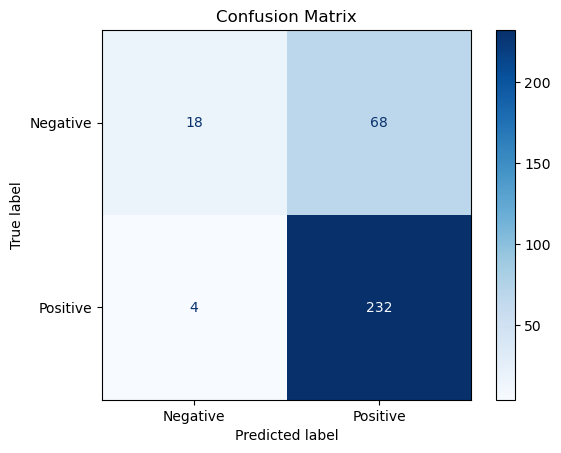

('Accuracy: 77.64%',
 'Precision: 78.53%',
 'Recall: 77.64%',
 'F1 score: 72.35%',
 None)

In [18]:
log_ev(df)

In [96]:
#Grid Search for Logistic Regression
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Prepare your data
sentences = dn['clean_text'].tolist()
labels = dn['result'].values  # Use .values to extract the values as a numpy array

# Custom transformer for Word2Vec
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_count=1, sg=0, alpha=0.025):
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.alpha = alpha
        self.model = None

    def fit(self, X, y=None):
        self.model = Word2Vec(X, window=self.window, min_count=self.min_count, sg=self.sg, alpha=self.alpha)
        return self

    def transform(self, X):
        X_transformed = []
        for sentence in X:
            vectors = []
            for word in sentence:
                if word in self.model.wv:
                    vectors.append(self.model.wv[word])
            if vectors:
                X_transformed.append(sum(vectors) / len(vectors))
            else:
                X_transformed.append([0] * self.model.vector_size)
        return X_transformed

# Define the pipeline with Word2Vec and logistic regression
pipeline = Pipeline([
    ('word2vec', Word2VecTransformer()),
    ('logistic', LogisticRegression())
])

# Define the parameter grid for grid search
param_grid = {
    'word2vec__window': [3, 5, 7],  # Maximum distance between the target word and its surrounding words
    'word2vec__min_count': [1, 3, 5],  # Minimum frequency required for a word to be included in the vocabulary
    'word2vec__sg': [0, 1],  # Training algorithm: 0 for CBOW, 1 for Skip-gram
    'word2vec__alpha': [0.01, 0.025, 0.05]  # Learning rate
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(sentences, labels)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)





KeyboardInterrupt: 

In [101]:
#Grid Search for Xgboost
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.metrics import recall_score

# Prepare your data
sentences = dn['clean_text'].tolist()
labels = dn['result'].values  # Use .values to extract the values as a numpy array

# Custom transformer for Word2Vec
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_count=1, sg=0, alpha=0.025):
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.alpha = alpha
        self.model = None

    def fit(self, X, y=None):
        self.model = Word2Vec(X, window=self.window, min_count=self.min_count, sg=self.sg, alpha=self.alpha)
        return self

    def transform(self, X):
        X_transformed = []
        for sentence in X:
            vectors = []
            for word in sentence:
                if word in self.model.wv:
                    vectors.append(self.model.wv[word])
            if vectors:
                X_transformed.append(sum(vectors) / len(vectors))
            else:
                X_transformed.append([0] * self.model.vector_size)
        return X_transformed

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Define the pipeline with Word2Vec and XGBoost
pipeline = Pipeline([
    ('word2vec', Word2VecTransformer()),
    ('xgboost', XGBClassifier())
])

# Define the parameter grid for grid search
param_grid = {
    'word2vec__window': [3, 5, 7],  # Maximum distance between the target word and its surrounding words
    'word2vec__min_count': [1, 3, 5],  # Minimum frequency required for a word to be included in the vocabulary
    'word2vec__sg': [0, 1],  # Training algorithm: 0 for CBOW, 1 for Skip-gram
    'word2vec__alpha': [0.01, 0.025, 0.05],  # Learning rate
}

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)



# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: {:.2f}%".format(recall * 100))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters:  {'word2vec__alpha': 0.05, 'word2vec__min_count': 1, 'word2vec__sg': 1, 'word2vec__window': 7}
Best Score:  0.745169366271529
Recall: 76.40%


In [ ]:
#xboost(accuracy) :{'word2vec__alpha': 0.01, 'word2vec__min_count': 1, 'word2vec__sg': 1, 'word2vec__window': 3}
#Logistic(accuracy) :{'word2vec__alpha': 0.01, 'word2vec__min_count': 3, 'word2vec__sg': 1, 'word2vec__window': 5}
#Best Hyperparameter-xgboost(recall):  {'word2vec__alpha': 0.05, 'word2vec__min_count': 1, 'word2vec__sg': 1, 'word2vec__window': 7}